# SETI Breakthrough Listen challenge solution based on pretrained NFNet RegNet model

An attempt to classify the SETI signals based on the Kaggle "SETI Breakthrough Listen - E.T. Signal Search" challenge:
- https://www.kaggle.com/competitions/seti-breakthrough-listen

This notebook uses a pretrained NF RegNet model to classify the SETI image dataset:
- https://rwightman.github.io/pytorch-image-models

This is based on the the first place solution for the Kaggle competition:
- https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266385
- https://www.kaggle.com/code/ligtfeather/eca-nfnet-sam-opt-mixup-k-folds-w-b

## Install Python Packages

Install packagese required to run this notebook.

In [1]:
# Pretrained models
!pip install timm

# Image transformations

!pip install albumentations

# PyTorch configured to run on GPU (CUDA)
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

# Evaluation metrics, such as accuracy
!pip install torchsummary

# Momentum based gradient descent optimizer
!pip install AdamP

# API for logging evaluation metrics to the cloud
!pip install wandb

## Import Python Packages

Import packages used in this notebook.

In [34]:
# Python utility packages
import os
import random
from collections import defaultdict
from datetime import datetime
import zipfile
from io import BytesIO

# PyTorhc packages for building, running and evaluating models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchsummary import summary
from torch.cuda.amp import GradScaler

# Scikit learn utility packages
from sklearn.decomposition import NMF # non-negative matrix factorisation
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score # evaluation metrics
from sklearn.model_selection import StratifiedKFold # Used for k-Folds cross validation

# OpenCV library used for image processing
import cv2

# Data and processing utility packages
import numpy as np
import pandas as pd

# Collection of pretrained models
import timm

# Momentum based gradient descent optimiser
from adamp import AdamP

# Batch processing helper
from tqdm import tqdm

# Image transformation helpers
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

# Utility for logging metrics using a cloud based API
import wandb

# Graph plotting library
from matplotlib import pyplot as plt

## Global Configuration

Create a configuration object for important values used in the notebook.

This makes them easy to track and tweak.

In [3]:
# Configuration object for important parameters used in the notebook
config = {
    'num_workers': 4,
    'model': 'tf_efficientnet_b3',
    'device': 'cuda',
    'image_size': 224,
    'input_channels': 1,
    'output_features': 1,
    'seed': 42,
    'target_size': 1,
    'T_max': 10,
    'min_lr': 1e-6,
    'lr': 1e-4,
    'weight_decay': 1e-8,
    'batch_size': 100,
    'epochs': 300,
    'num_folds': 3,    
    'wandb_project': 'SETI - setigen dataset - 3',
    'wandb_run_name': 'tf_efficientnet_b3'
}

## Random Seed Initialisation

Set random seeds to fixed values so the notebook results are reproducable.

In [4]:
'''
Sets seeds for randomness based functions.
'''
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


    
# Set the random seeds to a fixed value.    
set_seeds(seed=config['seed'])

## Data Loading

Load the SETI data samples into memory.

In [5]:
'''
Extract the data samples from a zip file and return in a dictionary object.
'''
def extract_zip(input_zip):
    zip_file = zipfile.ZipFile(input_zip)

    return {name: zip_file.read(name) for name in zip_file.namelist()}



# Extract the data samples from a zip file.
dataset = extract_zip('/datasets/setigen_1000/1000 setigen dataset.zip')

# Load the data samples labels in a dataframe for convenience.
initial_data_df = pd.read_pickle('/datasets/setigen_1000_labels/setigen_1000_dataset.pkl')

We can see that the data sample format include three fields:
- `id`: Containing the unique ID for the sample
- `target`: Indicates if the sample is positive (0) or negative (1)
- `image_filepath`: The location of the file containing the sample image data

In [6]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1000 non-null   object
 1   target          1000 non-null   int64 
 2   image_filepath  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


Split the data with 70% for a training set and 30% for a test set:

In [7]:
data_split_mask = np.random.rand(len(initial_data_df)) < 0.7

train_df = initial_data_df[data_split_mask]
test_df = initial_data_df[~data_split_mask]

## Image Processing Functions

Helper functions for processing the sample images.

In [8]:
'''
Resizes an image to the specified size.
'''
def resize_image(image):
    return cv2.resize(image, dsize=(config['image_size'], config['image_size']), interpolation=cv2.INTER_CUBIC)



'''
Plots an image.
'''
def plot_image(image):
    plt.figure(figsize = (20, 6))
    plt.imshow(image, aspect='auto')
    plt.show()


    
    
'''
Min-max normalises the image pixel values (between 0 and 1).
'''
def normalise_image(image):
    image_min = image.min()
    image_max = image.max()

    return (image - image_min) / (image_max - image_min)



'''
Factorises an image into two matrices, and returns them.
Used to help remove image background noise.
'''
def get_decomposition_matrices(image):
    norm_image = normalise_image(image)
    model = NMF(n_components=2, init='random', random_state=0)
    W = model.fit_transform(norm_image + 100) # add 100 to ensure no negative values
    H = model.components_

    return (W, H)



'''
Removes the background noise from a set of sample images.

Based on: https://www.kaggle.com/competitions/seti-breakthrough-listen/discussion/245950

This is the second version of this function.
The changes are to stack the 3 de-noised on target images horizontally, rather than add them in a single image.
'''
def get_denoised_image_2(sample_images):
    denoised_images = []

    for i in range(0, len(sample_images), 2):
        on_target_image = sample_images[i] # Get on target image
        off_target_image = sample_images[i+1] # Get off target image

        on_W, on_H = get_decomposition_matrices(on_target_image) # Decompose on target images into factor matrices
        off_W, off_H = get_decomposition_matrices(off_target_image) # Decompose off target images into factor matrices

        # Get noise approximation by multiplying a factor matrix from each of the on target, and off target images.
        # Then subtract the approximated noise from the on target image
        denoised_image = normalise_image(on_target_image - np.matmul(on_W, off_H))
        denoised_images.append(denoised_image)

    # combine the 3 de-noised on target images by appending them horizontally
    denoised_images = np.array(denoised_images)
    combined_image = np.hstack(denoised_images.reshape(3, 273, 256))

    return combined_image

## Custom Dataset

Create a custom dataset class.

This is used by the model to interact with a data sample.

In [9]:
class CustomDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        images_filepath = self.images_filepaths[idx]
        images_filepath = images_filepath.replace('\\', '/')
        file_name = os.path.basename(images_filepath)
        images_filepath = '1000 setigen dataset/' +  file_name
        
        images = np.load(BytesIO(dataset[images_filepath]), allow_pickle=True).astype(np.float32)
        # images = np.load(images_filepath).astype(np.float32)
        image = get_denoised_image_2(images)
            
        if self.transform is not None:
            image = self.transform(image=image)['image']
        else:
            image = resize_image(image)
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        
        label = torch.tensor(self.targets[idx]).float()

        return image, label

## Image Augmentation

Helper functions for transforming images.

These can be used to help prevent overfitting on the available data samples.

In [10]:
'''
Returns a set of image transformations using the albumentations library.
'''
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'], config['image_size']),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightnessContrast(brightness_limit=0.6, p=0.5),
            albumentations.CoarseDropout(max_holes=10, max_height=12, max_width=12, fill_value=0),
            albumentations.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.1, rotate_limit=0),
            ToTensorV2(p=1.0),
        ]
    )




'''
Applies transformations for validation image data.

This currently resizes the images.
'''
def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'],config['image_size']),
            ToTensorV2(p=1.0)
        ]
    )



'''
Applies transformations for training image data.

This currently resizes the images.
'''
def get_test_transforms():
        return albumentations.Compose(
            [
                albumentations.Resize(config['image_size'], config['image_size']),
                ToTensorV2(p=1.0)
            ]
        )

## Mixup

Mixup is an image augmentation technique that can also help prevent overfitting on the training data.

This works by overlaying two images by applying a transparency effect to the one on top.

In [11]:
'''
Given two images, x and y, use the alpha value to overlay them.
'''
def mixup(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :] # the composite image
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam




'''
Criterion to decide how much mixup to apply based on the sample prediction.

This allows the model to have a higher representation of samples that
it has a higher classification error on.
'''
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Metric Monitoring

Create utility class and function to track loss, accuracy and AUC ROC metrics.

Used with the Weights and Biases web API.

In [12]:
'''
Class used by Weights and Biases web API for metric monitoring.
'''
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {'val': 0, 'count': 0, 'avg': 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric['val'] += val
        metric['count'] += 1
        metric['avg'] = metric['val'] / metric['count']

    def __str__(self):
        return " | ".join(
            [
                '{metric_name}: {avg:.{float_precision}f}'.format(
                    metric_name=metric_name, avg=metric['avg'],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

    

'''
Helper method for returning the ROC AUC score for a prediction.
'''
def get_roc_auc(output, target):
    try:
        y_pred = torch.sigmoid(output).cpu()
        y_pred = y_pred.detach().numpy()
        target = target.cpu()

        return roc_auc_score(target, y_pred)
    except:
        return 0.5 # If an exception occurs, e.g. divide by zero, return a 0.5 score

## Weight Random Sampler

Returns a weighted sample from the training dataset.

The weighting helps ensure an equal amount of negative and positive samples are returned when there is an unequal distribution.

In [13]:
'''
Return a sample from the training data.

The sample selection is weighted so that there is an equal chance 
for a sample from each class being selected.
'''
def get_sampler(train_data):
    class_counts = train_data['target'].value_counts().to_list()
    num_samples = sum(class_counts)
    labels = train_data['target'].to_list()

    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[labels[i]] for i in range(int(num_samples))]

    return WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

## Train and Validation Dataloaders

Data loaders for the training and validation data.

These are used during the model training and validation loop.

In [14]:
def get_loaders(train_data, valid_data, sampler):
    training_set = CustomDataset(
        images_filepaths=train_data['image_filepath'].values,
        targets=train_data['target'].values,
        transform=get_train_transforms()
    )

    validation_set = CustomDataset(
        images_filepaths=valid_data['image_filepath'].values,
        targets=valid_data['target'].values,
        transform=get_valid_transforms()
    )

    train_loader = DataLoader(
        training_set,
        batch_size=config['batch_size'],
        # shuffle=True,
        # num_workers=config['num_workers'],
        sampler = sampler,
        pin_memory=True
    )

    valid_loader = DataLoader(
        validation_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

    return train_loader, valid_loader

## Model

The model that will be trained.

This is based on a pretrained ECA NFNet model.

The final layer is modified so the model outputs a binary classification.

In [15]:
'''
The model that is used for training and classification.

Based on a pretrained EfficientNet model.
'''
class EfficientNet(nn.Module):
    def __init__(self, model_name=config['model'], output_features=config['output_features'],
                 input_channels=config['input_channels'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=input_channels)

        # Modify final layer to allow for a binary classification
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, output_features, bias=True)
    
    def forward(self, x):
        x = self.model(x)

        return x

## Sharpness Aware Minimisation (SAM) Optimiser

This techniques helps find regions in the loss landscape that have a uniformly low loss value.

This helps avoid sharp dips in the loss value, which aids in model generalisation.

In [16]:
'''
Class implementing a PyTorch optimiser using the SAM technique.

Implementation from: https://github.com/layumi/AdaBoost_Seg/blob/master/sam.py
'''
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()

        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

## Network Initialisation

Initialise model, loss criterion, optimiser and learning rate scheduler.

In [17]:
# The model to train
model = EfficientNet()
model = model.to(config['device'])

# Loss criterion function for measuring loss
criterion = nn.BCEWithLogitsLoss().to(config['device'])

# Optimizer used for minimising loss during model training
base_optimizer = AdamP
optimizer = SAM(model.parameters(), base_optimizer, lr=config['lr'], weight_decay=config['weight_decay'])

# Learning rate scheduler.
# Starts from a high learning rate and steps down to a lower one.
scheduler = CosineAnnealingLR(optimizer,
                              T_max=config['T_max'],
                              eta_min=config['min_lr'],
                              last_epoch=-1)

A summary of the model is shown below.

We can see that it contains 184 layers, most of which are 2D convolutional and SiLU activation pairs.

There are a total of 21,808,125 model parameters.

In [18]:
summary(model.cuda(), (1, 1344, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 40, 672, 112]             360
          Identity-2         [-1, 40, 672, 112]               0
              SiLU-3         [-1, 40, 672, 112]               0
    BatchNormAct2d-4         [-1, 40, 672, 112]              80
            Conv2d-5         [-1, 40, 672, 112]             360
          Identity-6         [-1, 40, 672, 112]               0
              SiLU-7         [-1, 40, 672, 112]               0
    BatchNormAct2d-8         [-1, 40, 672, 112]              80
            Conv2d-9             [-1, 10, 1, 1]             410
             SiLU-10             [-1, 10, 1, 1]               0
           Conv2d-11             [-1, 40, 1, 1]             440
          Sigmoid-12             [-1, 40, 1, 1]               0
    SqueezeExcite-13         [-1, 40, 672, 112]               0
           Conv2d-14         [-1, 24, 6

## Model Training Function

The training function processes the training data in batches.

It makes predictions and then applies back propogation to reduce the loss.

The loss, accuracy and ROC AUC metrics are logged using the Weights and Biases wep API.

In [19]:
'''
Trains the model using training data batches
'''
def train(train_loader, model, criterion, optimizer, epoch, scheduler):
    metric_monitor = MetricMonitor() # Create the W&B metric monitor
    model.train() # Put the model in training mode so that weights can be updated
    stream = tqdm(enumerate(train_loader), total=len(train_loader)) # Create a stream for processing the data in batches

    # iterate over each batch
    for i, (images, target) in stream:
        images = images.to(config['device'])
        target = target.to(config['device']).float().view(-1, 1) # place the images in landscape view
        images, targets_a, targets_b, lam = mixup(images, target.view(-1, 1)) # get the images to classify

        optimizer.zero_grad() # reset the loss optimizer by zeroing its gradients

        output = model(images) # make predictions

        # calculate prediction accuracy
        accuracy = accuracy_score(target.cpu(), (output.cpu().detach().numpy() > 0), normalize=False)

        # calculate prediciton loss
        loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        
        # perform back propogation to update model weights
        loss.backward(retain_graph=True)

        # step the loss optimizer and reset it
        optimizer.first_step(zero_grad=False)
        optimizer.zero_grad()
        
        # update the mixup criterion based on image classification
        mixup_criterion(criterion, model(images), targets_a, targets_b, lam).backward()
        optimizer.second_step(zero_grad=False)
        
        # calculate ROC AUC score
        roc_auc = get_roc_auc(output, target)

        # update metrics in the metric monitor
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('Accuracy', accuracy)
        metric_monitor.update('ROC AUC', roc_auc)

        # log the metric with the W & B web API
        wandb.log({ 'Train Epoch': epoch, 'Train Loss': loss.item(), 'Train Accuracy': accuracy, 'Train ROC AUC': roc_auc })

        # update stream description so progress can be printed to screen
        stream.set_description(
            'Epoch: {epoch}. Train. {metric_monitor}'
            .format(epoch=epoch, metric_monitor=metric_monitor)
        )

    # update the learning rate scheduler
    scheduler.step()

## Model Validation Function

Used to measure the model performanc against the validation data set.

In [20]:
'''
Validation function measures model performance against the validation data set.

Metrics are reported to W & B API.
'''
def validate(val_loader, model, criterion, epoch):
    final_targets = []
    final_outputs = []

    metric_monitor = MetricMonitor()
    model.eval() # place model in validation mode so that weights are not updated
    stream = tqdm(enumerate(val_loader), total=len(val_loader))

    with torch.no_grad():
        for i, (images, target) in stream:
            images = images.to(config['device'], non_blocking=True)
            target = target.to(config['device'], non_blocking=True).float().view(-1, 1)

            output = model(images) # make predictions

            # calculate metrics
            loss = criterion(output, target)
            accuracy = accuracy_score(target.cpu(), (output.cpu().detach().numpy() > 0), normalize=False)
            roc_auc = get_roc_auc(output, target)

            # update metric monitor with metrics
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('Accuracy', accuracy)
            metric_monitor.update('ROC AUC', roc_auc)

            # report metrics to W & B API
            wandb.log(
                { 'Validation Epoch': epoch, 'Validation Loss': loss.item(), 'Validation Accuracy': accuracy, 'Validation ROC AUC': roc_auc }
            )

            stream.set_description(
                'Epoch: {epoch}. Validation. {metric_monitor}'
                .format(epoch=epoch, metric_monitor=metric_monitor)
            )
            
            # keep track of predictions and targets to allow further examination
            targets = target.detach().cpu().numpy().tolist()
            outputs = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(outputs)

    return final_outputs, final_targets

Create a directory to keep the best performing model state, so it can be reused in the future.

In [21]:
# name the directory with the current timestamp
current_datetime = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
models_dir = os.path.join('models', current_datetime)

os.mkdir(models_dir)

## Training and Validation Loop

This loop uses k-folds cross validation to segment the training data and uses the segments in different permutations for training 
and validation. Allowing the data to be used for more training cycles.

It both trains and validates the model for each fold.


The best performin model and metrics are stored for future reference.

In [22]:
# keep track of best metrics and best model state
best_roc_auc = -np.inf
best_epoch = -np.inf
best_model_name = None
best_model_state = None

# create the folds for k-folds cross validation
k_fold = StratifiedKFold(n_splits=config['num_folds'], shuffle=True, random_state=config['seed'])



# iterate through each fold
for fold, (trn_idx, val_idx) in enumerate(k_fold.split(train_df, train_df['target'])):
    # initialise W&B for storing the metrics in
    wandb.init(
        project=config['wandb_project'],
        config=config,
        job_type='train',
        name=config['wandb_run_name']
    )

    # print the current fold
    print(f"{'='*40} Fold: {fold} {'='*40}")

    # get the training and validation samples
    train_data = train_df.iloc[trn_idx]
    valid_data = train_df.iloc[val_idx]

    # initialise the data sampler on the training data
    sampler = get_sampler(train_data)

    # get the training and validation data loaders
    train_loader, valid_loader = get_loaders(train_data, valid_data, sampler)

    # iterater through each training epoch
    for epoch in range(1, config['epochs'] + 1):
        # perform the model training and validation
        train(train_loader, model, criterion, optimizer, epoch, scheduler)
        valid_predictions, valid_targets = validate(valid_loader, model, criterion, epoch)

        # calculate the validation ROC AUC
        valid_roc_auc = round(roc_auc_score(valid_targets, valid_predictions), 3)

        # keep the metrics and model state for the predictions with the best validation ROC AUC 
        if valid_roc_auc > best_roc_auc:
            best_roc_auc = valid_roc_auc
            best_epoch = epoch
            best_model_name = f"{config['model']}_fold_{fold}_epoch_{epoch}_roc_auc_{valid_roc_auc}.pth"
            best_model_state = model.state_dict()

    # save the best performing model state
    torch.save(best_model_state, os.path.join(models_dir, best_model_name))

    # print the best ROC AUC scores and model state for the fold
    print(f'Best ROC-AUC in fold {fold} was {best_roc_auc:.4f}')
    print(f'Final ROC-AUC in fold {fold} was {valid_roc_auc:.4f}')
    print(f'Best model name in fold {fold} was {best_model_name}')

wandb: Currently logged in as: mllm3. Use `wandb login --relogin` to force relogin


======================================== Fold: 0 ========================================


Epoch: 1. Train. Loss: 0.692 | Accuracy: 47.800 | ROC AUC: 0.521: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]
/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch: 1. Validation. Loss: 0.699 | Accuracy: 37.333 | ROC AUC: 0.528: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]
Epoch: 2. Train. Loss: 0.684 | Accuracy: 52.400 | ROC AUC: 0.565: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
Epoch: 2. Validation. Loss: 0.700 | Accuracy: 41.000 | ROC AUC: 0.543: 100%|██████████| 3/3 [00:03<00:00,  1.04s

Best ROC-AUC in fold 0 was 0.6460
Final ROC-AUC in fold 0 was 0.5740
Best model name in fold 0 was tf_efficientnet_b3_fold_0_epoch_13_roc_auc_0.646.pth


Train Accuracy,▄▄▁▄▁▅▃▃▄▅▅▃▆▅▇▄▆▇▆▃█▂▆▄█▅▇█▇▃▇▃▇▄▇▅▄▆▂▄
Train Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,▇▇▇▇▇▆▇▆▇▆▇▇▅▆▃▃▆▅▄▅▁▄▅▆▁▆▃▃▁▃▂▅▃▃▄▇▄▅█▂
Train ROC AUC,▃▄▂▅▁▅▅▂▃▅▅▃▆▃▇▂▆▇▇▄█▃▇▆█▅███▂█▂█▂▇▅█▇▃▃
Validation Accuracy,▁▂▂▂▂▂▂▇█▆▇▇▇▇▆▄▅▄▄▄▂▂▂▂▂▁▁█▇▇▇█▆▅▃▄▄▃▅▅
Validation Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Validation Loss,▅▃▂▁▁▁▁▅▅▆▅▅▅▅▅▆▆▇▆▇▁▁▁▁▁▂▂▅▆▆▆▅▆▆█▇█▇▇▇
Validation ROC AUC,█▁▁▁▁▁▁▁▁▁▁▁▁▁▅▃▃▂▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂
Train Accuracy,55
Train Epoch,300
Train Loss,0.58512


======================================== Fold: 1 ========================================


Epoch: 1. Train. Loss: 0.647 | Accuracy: 64.800 | ROC AUC: 0.760: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
Epoch: 1. Validation. Loss: 0.151 | Accuracy: 78.333 | ROC AUC: 0.667: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]
Epoch: 2. Train. Loss: 0.556 | Accuracy: 57.800 | ROC AUC: 0.655: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
Epoch: 2. Validation. Loss: 0.160 | Accuracy: 78.000 | ROC AUC: 0.667: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]
Epoch: 3. Train. Loss: 0.627 | Accuracy: 66.800 | ROC AUC: 0.763: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
Epoch: 3. Validation. Loss: 0.186 | Accuracy: 78.000 | ROC AUC: 0.667: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]
Epoch: 4. Train. Loss: 0.533 | Accuracy: 70.600 | ROC AUC: 0.831: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]
Epoch: 4. Validation. Loss: 0.191 | Accuracy: 77.667 | ROC AUC: 0.667: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]
Epoch: 5. Train. Loss: 0.543 | Accuracy: 62.600 | ROC AUC: 0.709: 100%|██████████| 5

Best ROC-AUC in fold 1 was 1.0000
Final ROC-AUC in fold 1 was 0.9000
Best model name in fold 1 was tf_efficientnet_b3_fold_1_epoch_2_roc_auc_1.0.pth


Train Accuracy,▆▃▁▄▃▃▃▅▅▃▇▄▂▂▇▂▃▇▇▁▆▁▂▂▄▅▃▆▅▁█▂▆▆▇▅▃▇▂▆
Train Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,▅▆▇▇█▇█▇█▆▅▂▆▄▄▃▅▃▄▂▆▃▄▆▆▇▅▆▇▃▁▅▇▆▆▇▇▃▆▆
Train ROC AUC,▇▃▂▄▅▂▆▅▅▃▇▃▂▃█▂▄██▃▆▄▂▄▄▇▃▇▅▁█▂▆▇▇▅▆█▄▆
Validation Accuracy,█▁▁▁▂▁▂▇▇▇▇▇▇█▆▆▆▆▆▆▁▁▁▁▁▁▁▇▇▇▆▇▇▆▅▅▆▅▆▆
Validation Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Validation Loss,▂▁▁▁▁▁▁▃▄▃▃▄▃▃▅▆▅▅▅▆▂▁▃▃▂▂▃▅▄▅▅▅▅▇█▇▇▇▇▇
Validation ROC AUC,█▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇▇▆▆▇▁▁▁▁▁▁▁▁▁▁▁▁▁▆▆▆▆▆▆▆
Train Accuracy,47
Train Epoch,300
Train Loss,0.41349


======================================== Fold: 2 ========================================


Epoch: 1. Train. Loss: 0.516 | Accuracy: 67.200 | ROC AUC: 0.761: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]
Epoch: 1. Validation. Loss: 0.091 | Accuracy: 79.000 | ROC AUC: 0.667: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it] 
Epoch: 2. Train. Loss: 0.434 | Accuracy: 70.200 | ROC AUC: 0.781: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
Epoch: 2. Validation. Loss: 0.081 | Accuracy: 79.000 | ROC AUC: 0.667: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it] 
Epoch: 3. Train. Loss: 0.503 | Accuracy: 66.200 | ROC AUC: 0.746: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]
Epoch: 3. Validation. Loss: 0.104 | Accuracy: 78.667 | ROC AUC: 0.667: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]
Epoch: 4. Train. Loss: 0.543 | Accuracy: 60.600 | ROC AUC: 0.671: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
Epoch: 4. Validation. Loss: 0.117 | Accuracy: 78.667 | ROC AUC: 0.667: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]
Epoch: 5. Train. Loss: 0.513 | Accuracy: 61.000 | ROC AUC: 0.681: 100%|██████████|

Best ROC-AUC in fold 2 was 1.0000
Final ROC-AUC in fold 2 was 0.9910
Best model name in fold 2 was tf_efficientnet_b3_fold_1_epoch_2_roc_auc_1.0.pth


## Model Evaluation

Now the best performing model will run against the test data.

This gives a good indication of real life model performance, because the model has not seen the test data at this point.

In [24]:
# manually load best model as training run was interrupted
best_model_name = 'tf_efficientnet_b3_fold_1_epoch_2_roc_auc_1.0.pth'
best_model_state = torch.load(os.path.join('models/22-09-10_02-21-33', best_model_name))

In [25]:
'''
Data loader for the test data.
'''

def get_test_loader(test_data):
    test_set = CustomDataset(
        images_filepaths=test_data['image_filepath'].values,
        targets=test_data['target'].values
    )

    return DataLoader(
        test_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

    return test_loader

Run the model agains the test data and log the metrics:

In [29]:
'''
Function for testing a model against the test dataset.

It returns the model predictions for the ground truth labels.
'''
def test_model(model_state):
    # keep track of the predictions and ground truth labels
    final_targets = []
    final_outputs = []

    # initialise the model and place it in evaluation mode
    model = EfficientNet()
    model.load_state_dict(model_state)
    model.eval()

    # initialise the metric monitor for reporting progress
    metric_monitor = MetricMonitor()
    
    # initialise the test data loader with the test data
    test_loader = get_test_loader(test_df)
    
    # create the stream for iterating through the test data batch
    stream = tqdm(enumerate(test_loader), total=len(test_loader))

    with torch.no_grad(): # don't perform any back propogation as we only want to evaluate
        for i, (images, target) in stream: # iterate through each test data batch
            images = images.to('cpu', non_blocking=True)
            target = target.to('cpu', non_blocking=True).float().view(-1, 1)

            # make predictions
            output = model(images)

            # calculate metric performance metrics
            loss = criterion(output, target)
            accuracy = accuracy_score(target.cpu(), (output.cpu().detach().numpy() > 0), normalize=False)
            roc_auc = get_roc_auc(output, target)

            # report the metrics to the monitor for displaying model progress
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('ROC AUC', roc_auc)

            # report the metrics the W&B web API
            wandb.log({'Test Loss': loss.item(), 'Test Accuracy': accuracy, 'Test ROC AUC': roc_auc})

            # print the current model progress
            stream.set_description('Test {metric_monitor}'.format(metric_monitor=metric_monitor))

            # get the ground truth labels and predictions so they can be returned
            targets = target.detach().cpu().numpy().tolist()
            outputs = output.detach().cpu().numpy().tolist()

            final_targets.extend(targets)
            final_outputs.extend(outputs)

    # return predictions and ground truth labels
    return final_outputs, final_targets

Run the model against the test set:

In [30]:
test_outputs, test_targets = test_model(best_model_state)

Test Loss: 0.789 | ROC AUC: 0.541: 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]


Create a dataframe with the predictions and ground truch labels to help make the result evaluation easier:

In [47]:
test_results_df = pd.DataFrame([test_targets, test_outputs])
test_results_df = test_results_df.transpose()
test_results_df.columns = ['label', 'prediction']

test_results_df['label'] = test_results_df['label'].apply(lambda x: x[0])
test_results_df['prediction'] = test_results_df['prediction'].apply(lambda x: x[0])

Plot ROC curve:

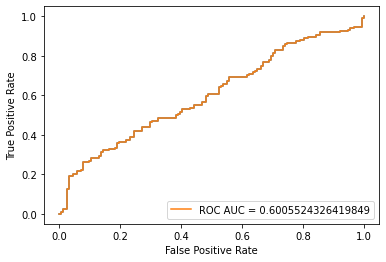

In [48]:
'''
Plot ROC curve, with a label for ROC AUC.
'''
def plot_roc_curve(targets, predictions):
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = roc_auc_score(targets, predictions)
    
    plt.plot(fpr,tpr)

    plt.plot(fpr, tpr, label="ROC AUC = " + str(roc_auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)

    plt.show()
    
    
    
plot_roc_curve(test_results_df['label'], test_results_df['prediction'])

Get optimal threshold with highest TPR vs. FPR:

In [49]:
'''
Returns threshold from ROC curve that gives highest
True Positive Rate vs. False Positive Rate.
'''
def get_optimal_threshold(targets, predictions):
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    
    return list(roc_t['threshold'])[0]



optimal_threshold = get_optimal_threshold(test_targets, test_results_df['prediction'])
print('Optimal threshold:', optimal_threshold)

Optimal threshold: -0.12367027997970581


Use optimal threshold to perform binary classification:

In [50]:
test_results_df['classification'] = [0 if x < optimal_threshold else 1.0 for x in test_results_df['prediction']]

Display a confusion matrix for an overview of how well the model predicted each class:

In [51]:
pd.crosstab(test_results_df['classification'], test_results_df['label'])

label,0.0,1.0
classification,,
0.0,86,60
1.0,68,74


Display the standard metrics for the test results:

In [52]:
print(classification_report(test_results_df['classification'], test_results_df['label']))

              precision    recall  f1-score   support

         0.0       0.56      0.59      0.57       146
         1.0       0.55      0.52      0.54       142

    accuracy                           0.56       288
   macro avg       0.56      0.56      0.55       288
weighted avg       0.56      0.56      0.56       288

